<a href="https://colab.research.google.com/github/LukeFic/AE370/blob/main/370Project1Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Tuned Mass Dampers to Reduce Effects of Earthquakes

#### Initalize the parameters and universal functions

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Variables
m1 = 1000.0     # Mass Building [kg]
f1 = 1.0        # Natural frequency of building [Hz]
zeta1 = 0.02    # Damping ratio of building
TMD_ratio = 0.02  # Ratio of TMD mass to building mass

m2 = m1 * TMD_ratio  # Mass TMD [kg]
f2 = 1.0             # Natural frequency of TMD (tuned to f1)
zeta2 = 0.05         # Damping ratio of TMD

f0 = 1.0        # Frequency of Ricker//Earthquake [Hz]
A = 1.0         # Amplitude [m/s^2]
t_center = 1.0  # Peak Time[s]

dt = 0.002      # Time step [s]
T = 30.0        # Total simulation time [s]

# Derived (building base case)
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

k1 = m1 * omega1**2
k2 = m2 * omega2**2
c1 = 2 * zeta1 * m1 * omega1
c2 = 2 * zeta2 * m2 * omega2


# Ground motion (Ricker wavelet)
def ricker(t, f0):
    a = np.pi * f0 * t
    return (1 - 2 * a**2) * np.exp(-a**2)

t = np.arange(0, T + dt, dt)
ag = A * ricker(t - t_center, f0)  # Ground acceleration [m/s^2]

# Precompute ground displacement/velocity once
def cumtrapz_np(y, dt):
    out = np.zeros_like(y)
    if len(y) > 1:
        out[1:] = np.cumsum(0.5 * (y[1:] + y[:-1])) * dt
    return out
vg = cumtrapz_np(ag, dt)
xg = cumtrapz_np(vg, dt)


#### Define our trapazoidal function that we can use throughout our analysis

In [19]:
def trapezoidal_rule(M, C, K, ag, dt, T):
    """
    Integrates relative motion r for a 2-DOF base-excited system:
      M r̈ + C ṙ + K r = -M * 1 * ag
    using the trapezoidal method.

    Args:
        M, C, K: (2x2) numpy arrays
        ag: (n,) ground acceleration array
        dt: time step
        T: total time

    Returns:
        t, r, r_dot, r_ddot  (all relative to ground)
    """
    t = np.arange(0, T + dt, dt)
    n = len(t)

    r = np.zeros((n, 2))
    r_dot = np.zeros((n, 2))
    r_ddot = np.zeros((n, 2))

    # Effective matrix is constant for constant dt
    K_eff = M + 0.5 * dt * C + 0.25 * dt**2 * K
    K_eff_inv = np.linalg.inv(K_eff)

    # Base inertia vector (multiply by ag[k] each step)
    Gamma = -M.dot(np.array([1.0, 1.0]))

    # Initial acceleration: M r̈0 = Γ ag0 - C ṙ0 - K r0
    r_ddot[0] = np.linalg.solve(M, Gamma * ag[0] - C @ r_dot[0] - K @ r[0])

    for k in range(n - 1):
        F_next = 0.5 * Gamma * (ag[k] + ag[k + 1]) 
        rhs = (F_next
               - C.dot(r_dot[k] + 0.5 * dt * r_ddot[k])
               - K.dot(r[k] + 0.5 * dt * r_dot[k] + 0.25 * dt**2 * r_ddot[k]))
        r_ddot[k + 1] = K_eff_inv.dot(rhs)
        r_dot[k + 1]  = r_dot[k] + 0.5 * dt * (r_ddot[k] + r_ddot[k + 1])
        r[k + 1]      = r[k]     + dt * r_dot[k] + 0.25 * dt**2 * (r_ddot[k] + r_ddot[k + 1])

    return t, r, r_dot, r_ddot

#### Plot our system using the numerical solution. We plot position, velocity and acceleration for the building itself and the damper

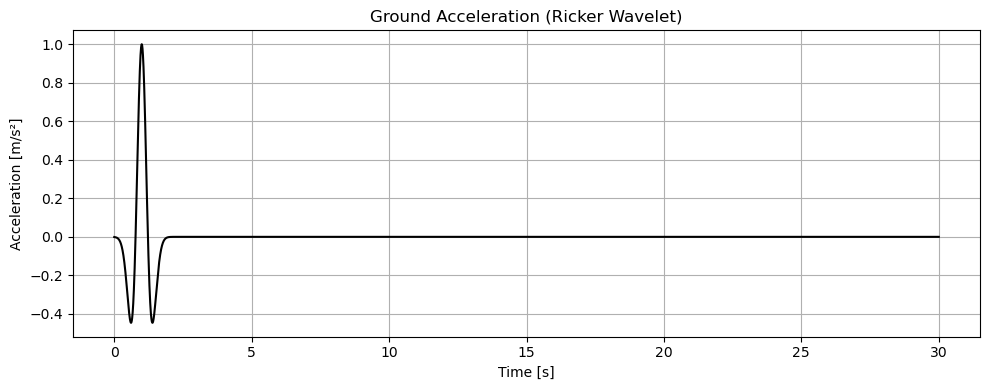

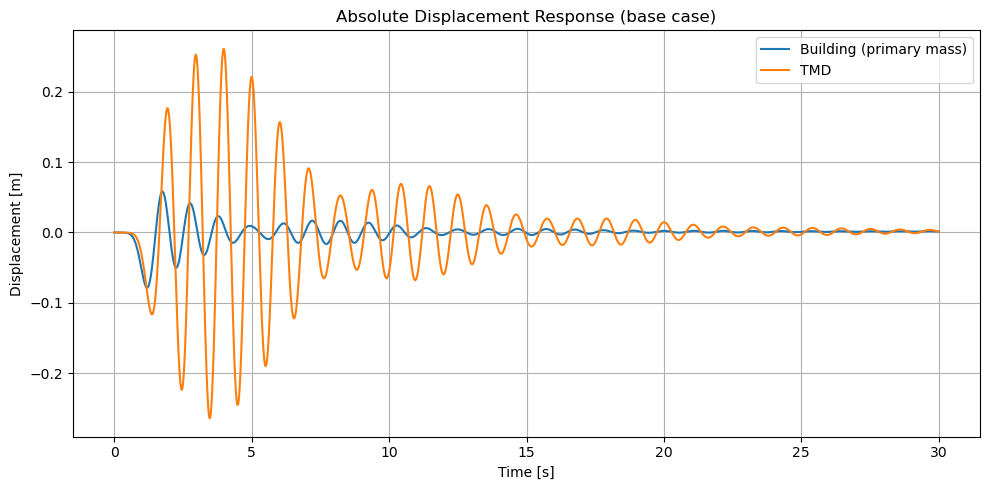

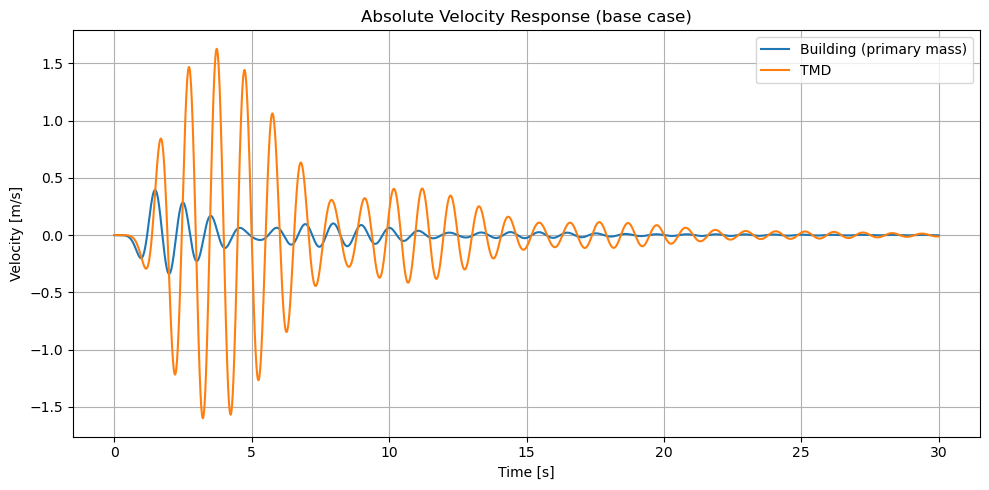

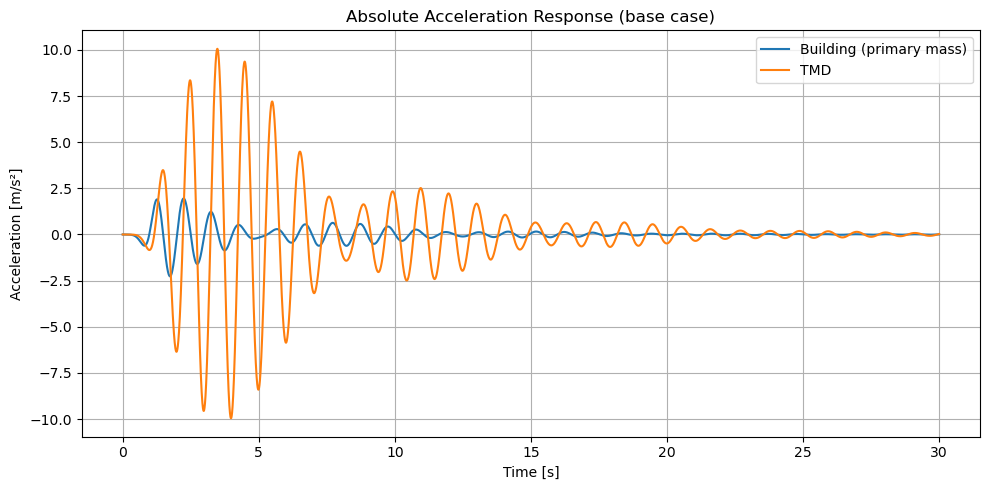

Peak Displacement (Building): 0.0785 m
Peak Displacement (TMD):      0.2639 m
Peak Velocity (Building):     0.3942 m/s
Peak Velocity (TMD):          1.6274 m/s
Peak Accel (Building):        2.2680 m/s²
Peak Accel (TMD):             10.0604 m/s²


In [20]:

# Base 2-DOF run
M = np.array([[m1, 0.0],
              [0.0, m2  ]])
C = np.array([[c1 + c2, -c2],
              [-c2,      c2]])
K = np.array([[k1 + k2, -k2],
              [-k2,      k2]])

_, r, r_dot, r_ddot = trapezoidal_rule(M, C, K, ag, dt, T)
u      = r      + xg.reshape(-1, 1) * np.array([1.0, 1.0])
u_dot  = r_dot  + vg.reshape(-1, 1) * np.array([1.0, 1.0])
u_ddot = r_ddot + ag.reshape(-1, 1) * np.array([1.0, 1.0])

# Plots for this base case
plt.figure(figsize=(10, 4))
plt.plot(t, ag, color='black')
plt.title('Ground Acceleration (Ricker Wavelet)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u[:, 0], label='Building (primary mass)')
plt.plot(t, u[:, 1], label='TMD')
plt.title('Absolute Displacement Response (base case)')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_dot[:, 0], label='Building (primary mass)')
plt.plot(t, u_dot[:, 1], label='TMD')
plt.title('Absolute Velocity Response (base case)')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_ddot[:, 0], label='Building (primary mass)')
plt.plot(t, u_ddot[:, 1], label='TMD')
plt.title('Absolute Acceleration Response (base case)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Peak Displacement (Building): {np.max(np.abs(u[:,0])):.4f} m")
print(f"Peak Displacement (TMD):      {np.max(np.abs(u[:,1])):.4f} m")
print(f"Peak Velocity (Building):     {np.max(np.abs(u_dot[:,0])):.4f} m/s")
print(f"Peak Velocity (TMD):          {np.max(np.abs(u_dot[:,1])):.4f} m/s")
print(f"Peak Accel (Building):        {np.max(np.abs(u_ddot[:,0])):.4f} m/s²")
print(f"Peak Accel (TMD):             {np.max(np.abs(u_ddot[:,1])):.4f} m/s²")


#### We now find the analytical solution for the system using scipy. The same graphs as above are shown for the analytical solution

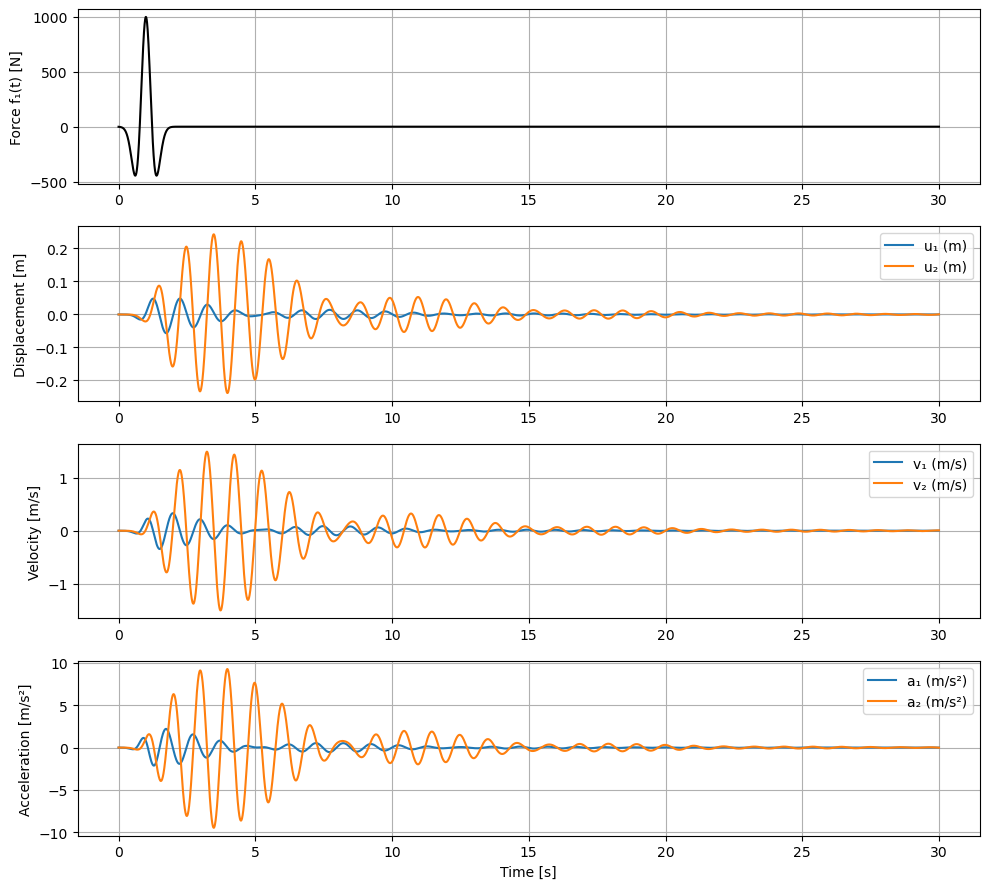

In [21]:
#analytical solution
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def f1(t):
    return m1*ricker(t - 1.0, f0)   # centered at t = 1

# State equations 
def xdot(t, x):
    x1, x2, x3, x4 = x  # [u1, u1dot, u2, u2dot]
    dx1 = x2
    dx2 = (1.0/m1) * ( f1(t) - (c1+c2)*x2 + c2*x4 - (k1+k2)*x1 + k2*x3 )
    dx3 = x4
    dx4 = (1.0/m2) * ( c2*(x2 - x4) + k2*(x1 - x3) )
    return [dx1, dx2, dx3, dx4]

# Initial conditions and time span
x0 = [0.0, 0.0, 0.0, 0.0]
t_span = (0.0, 30.0)
t_eval = np.linspace(t_span[0], t_span[1], 4001)

# Integrate 
sol = solve_ivp(xdot, t_span, x0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

t = sol.t
u1, v1, u2, v2 = sol.y

#  Compute accelerations directly from ODEs 
a1 = (1.0/m1)*( f1(t) - (c1+c2)*v1 + c2*v2 - (k1+k2)*u1 + k2*u2 )
a2 = (1.0/m2)*( c2*(v1 - v2) + k2*(u1 - u2) )

# Plot results
plt.figure(figsize=(10,9))

plt.subplot(4,1,1)
plt.plot(t, f1(t), 'k')
plt.ylabel('Force f₁(t) [N]')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t, u1, label='u₁ (m)')
plt.plot(t, u2, label='u₂ (m)')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t, v1, label='v₁ (m/s)')
plt.plot(t, v2, label='v₂ (m/s)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(t, a1, label='a₁ (m/s²)')
plt.plot(t, a2, label='a₂ (m/s²)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Uses our analytical solution as a refrence and finds the relationship between dt and the RMS error

<>:98: SyntaxWarning: invalid escape sequence '\D'
<>:101: SyntaxWarning: invalid escape sequence '\D'
<>:98: SyntaxWarning: invalid escape sequence '\D'
<>:101: SyntaxWarning: invalid escape sequence '\D'
C:\Users\lafic\AppData\Local\Temp\ipykernel_33512\3490203288.py:98: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dt_theoretical, error_theoretical, '--', color='red', label='Theoretical Order ~ $\Delta t^2$')
C:\Users\lafic\AppData\Local\Temp\ipykernel_33512\3490203288.py:101: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta t$ [s]')


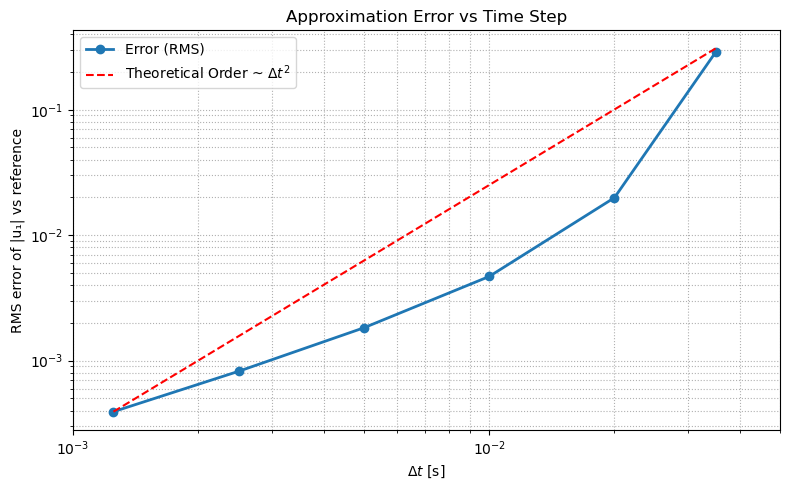

Δt: [0.00125 0.0025  0.005   0.01    0.02    0.035  ]
error: [0.0003922  0.00082334 0.0018289  0.0046874  0.01989358 0.28667444]
Observed order ≈ 2.09  (expect ~2 for trapezoidal)


In [22]:
import matplotlib.pyplot as plt

# Helper: run absolute building response at a given dt
def simulate_building_abs(M, C, K, dt, T, f0, A, t_center):
    """
    Integrates the 2-DOF system for a given dt and returns the absolute building displacement.
    """
    t  = np.arange(0, T + dt, dt)
    ag = A * ricker(t - t_center, f0)

    # integrate relative motion
    _, r, _, _ = trapezoidal_rule(M, C, K, ag, dt, T)

    # 2nd-order ground kinematics
    vg = cumtrapz_np(ag, dt)
    xg = cumtrapz_np(vg, dt)

    u_building = r[:, 0] + xg   # absolute building displacement u1
    return t, u_building

def xdot_rel(t, x):
    # state: [r1, r1dot, r2, r2dot]
    r1, v1, r2, v2 = x
    ag_t = A * ricker(t - t_center, f0)

    # M r̈ + C r˙ + K r = -M * 1 * ag
    # explicit 2-DOF:
    a1 = ( - (c1 + c2)*v1 + c2*v2 - (k1 + k2)*r1 + k2*r2 - m1*ag_t ) / m1
    a2 = (   c2*v1 - c2*v2 + k2*r1 - k2*r2 - m2*ag_t ) / m2
    return [v1, a1, v2, a2]

def reference_u1(T, m1, m2, c1, c2, k1, k2, f0, A, t_center, n_eval=12001):
    t_ref = np.linspace(0.0, T, n_eval)
    sol = solve_ivp(
        xdot_rel, (0.0, T), [0.0, 0.0, 0.0, 0.0], t_eval=t_ref,
        rtol=1e-10, atol=1e-12
    )
    # recover absolute u1 = r1 + xg
    ag_ref = A * ricker(t_ref - t_center, f0)
    vg_ref = cumtrapz_np(ag_ref, t_ref[1]-t_ref[0])
    xg_ref = cumtrapz_np(vg_ref, t_ref[1]-t_ref[0])
    u1_ref = sol.y[0, :] + xg_ref
    return t_ref, u1_ref

def approximation_error_vs_dt(dt_list, M, C, K, T, f0, A, t_center,
                              norm="rms", make_plot=True, fit_slice=None):

    dt_list = np.array(sorted(dt_list))

    # reference once
    t_ref, u_ref = reference_u1(T, m1, m2, c1, c2, k1, k2, f0, A, t_center, n_eval=12001)

    errors = []
    for dt in dt_list:
        t_i, u_i = simulate_building_abs(M, C, K, dt, T, f0, A, t_center)
        u_ref_i  = np.interp(t_i, t_ref, u_ref)
        if norm.lower() == "rms":
            e = np.sqrt(np.mean((u_i - u_ref_i)**2))
        elif norm.lower() == "max":
            e = np.max(np.abs(u_i - u_ref_i))
        else:  # 'l1'
            e = np.mean(np.abs(u_i - u_ref_i))
        errors.append(e)
    errors = np.array(errors)

    # choose which points to fit
    if fit_slice is None:
        fit_slice = slice(1, None)  # ignore the first
    p, b = np.polyfit(np.log(dt_list[fit_slice]), np.log(errors[fit_slice] + 1e-300), 1)

    if make_plot:
    # For plotting only: replace non-finite and zeros with a tiny positive value or drop them
        eps = 1e-300
        errors_plot = np.where(np.isfinite(errors), errors, np.nan)
        mask = np.isfinite(errors_plot) & (errors_plot > 0)

        if mask.sum() == 0:
            raise ValueError("All errors are non-finite or zero; nothing to plot on log axes.")

        plt.figure(figsize=(8, 5))
        plt.loglog(dt_list[mask], errors_plot[mask], marker='o', linewidth=2, markersize=6,
               label=f'Error ({norm.upper()})')

        # Plot theoretical order 2 line (x^2 line)
        if mask.sum() > 0:
            # Anchor theoretical line to the first valid data point
            first_dt_masked = dt_list[mask][0]
            first_error_masked = errors_plot[mask][0]

            # Theoretical line: error = C * dt^2
            # log(error) = log(C) + 2 * log(dt)
            # C = error / dt^2
            C_theoretical = first_error_masked / (first_dt_masked**2)

            # Generate points for the theoretical line across the same dt range
            dt_theoretical = np.logspace(np.log10(dt_list[mask].min()), np.log10(dt_list[mask].max()), 100)
            error_theoretical = C_theoretical * (dt_theoretical**2)
            plt.loglog(dt_theoretical, error_theoretical, '--', color='red', label='Theoretical Order ~ $\Delta t^2$')

        plt.title('Approximation Error vs Time Step')
        plt.xlabel('$\Delta t$ [s]')
        plt.ylabel(f'{norm.upper()} error of |u₁| vs reference')
        plt.grid(True, which='both', linestyle=':')
        plt.legend()
        plt.tight_layout()
        plt.xlim([1e-3,.5e-1])
        plt.show()


    return {'dt': dt_list, 'error': errors, 'order': p}

# solve for range of dts
dt_sweep = [2e-2, 1e-2, 5e-3, 2.5e-3, 1.25e-3, .035]
res = approximation_error_vs_dt(
    dt_sweep, M, C, K, T, f0, A, t_center,
    norm="rms", make_plot=True, fit_slice=slice(1, None)
)
print("Δt:", res['dt'])
print("error:", res['error'])
print(f"Observed order ≈ {res['order']:.2f}  (expect ~2 for trapezoidal)")

#### Helper function for simulating the system with a varying damper mass

In [23]:
def simulate_displacement(tmd_masses, dt, T, zeta1, zeta2,
                          m1_fixed, k1_fixed, f0, A, t_center):
    """
    Returns a list of dicts. Each dict has:
      'time' (N+1,), 'displacement' (N+1, 2), 'tmd_mass', 'tmd_k'
    Displacement columns: [:,0]=building abs, [:,1]=TMD abs
    """
    # Build a time base and ground motion (N+1 samples)
    t  = np.arange(0.0, T + dt, dt)
    ag = A * ricker(t - t_center, f0)

    results = []
    for m2 in tmd_masses:
        # Tune k2 to the same natural frequency as DOF1: ω1^2 = k1/m1
        omega1 = np.sqrt(k1_fixed / m1_fixed)
        k2 = m2 * omega1**2

        # Rayleigh-ish damping for each DOF (series connection in 2DOF model)
        c1 = 2.0 * zeta1 * np.sqrt(k1_fixed * m1_fixed)
        c2 = 2.0 * zeta2 * np.sqrt(k2 * m2)

        M = np.array([[m1_fixed, 0.0],
                      [0.0,      m2]])
        C = np.array([[c1 + c2, -c2],
                      [-c2,       c2]])
        K = np.array([[k1_fixed + k2, -k2],
                      [-k2,            k2]])

        # Integrate relative motion r (shape (N+1, 2))
        _, r, _, _ = trapezoidal_rule(M, C, K, ag, dt, T)

        # Ground kinematics
        vg = cumtrapz_np(ag, dt)
        xg = cumtrapz_np(vg, dt)

        # Absolute displacements: u = r + xg
        u_abs = r + xg[:, None]  # (N+1,2)

        results.append({
            'time': t,
            'displacement': u_abs,
            'tmd_mass': m2,
            'tmd_k': k2
        })
    return results


#### Find how the mass of the damper effects the reduction in displacement. We are also adjusting k to keep the frequencys of the system lined up

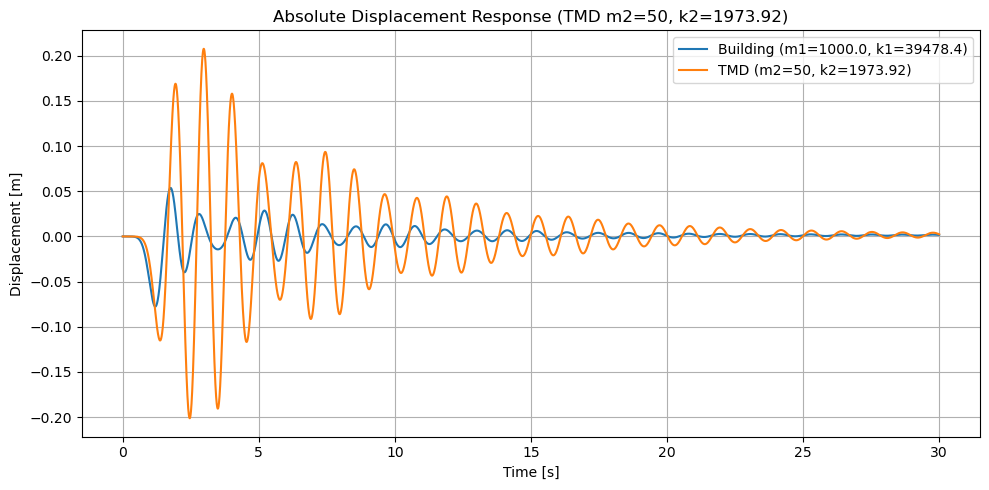

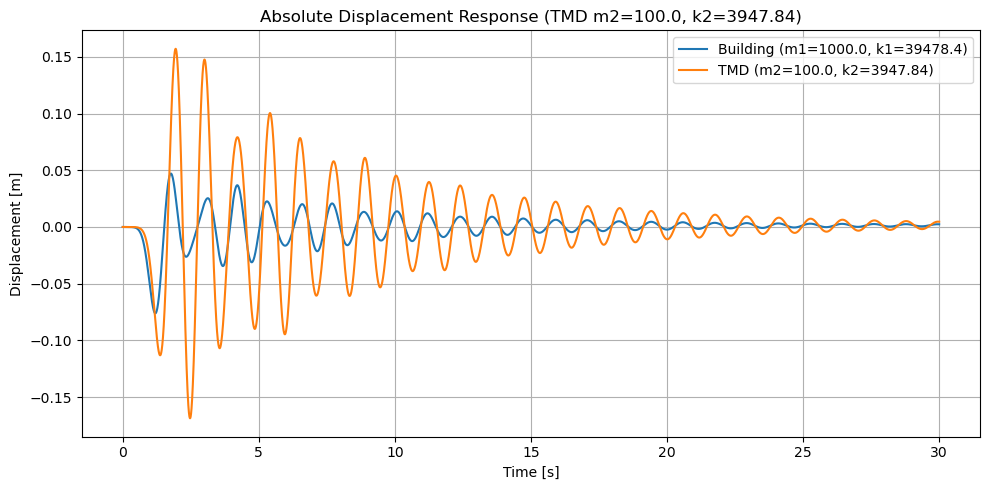

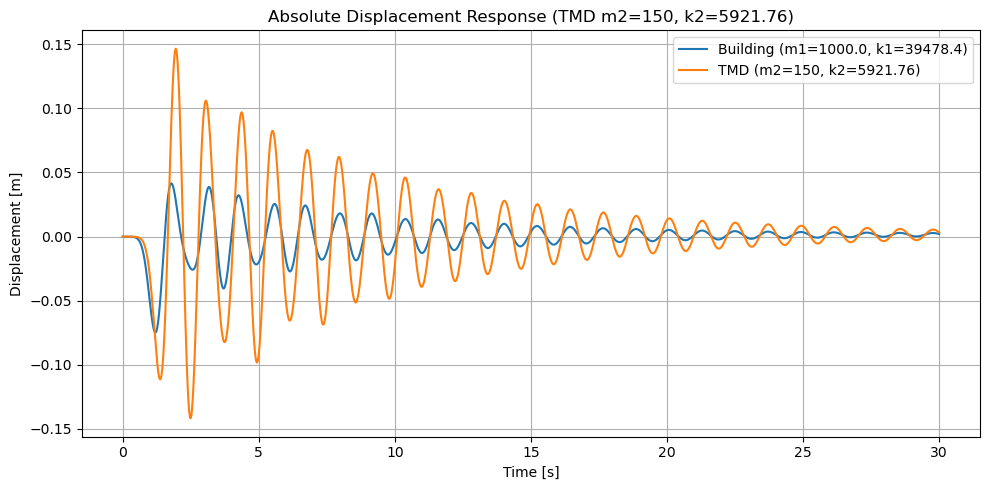

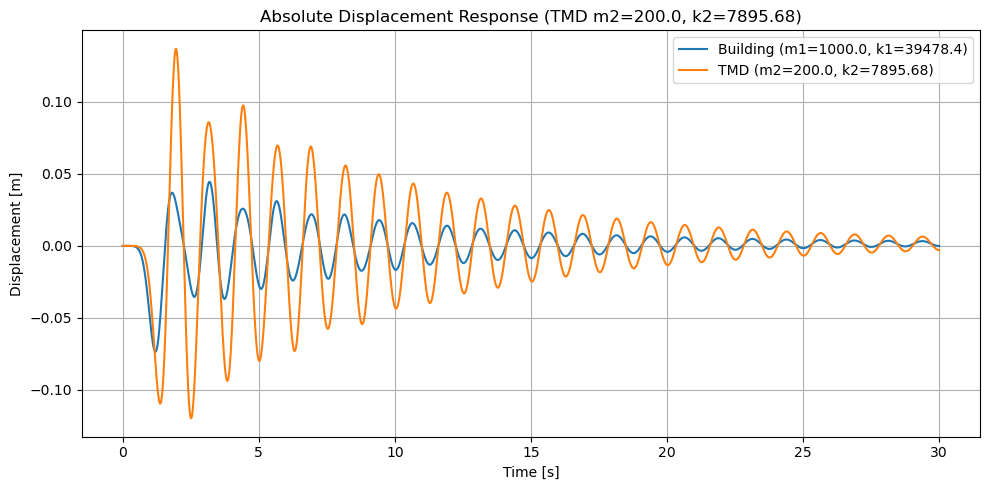

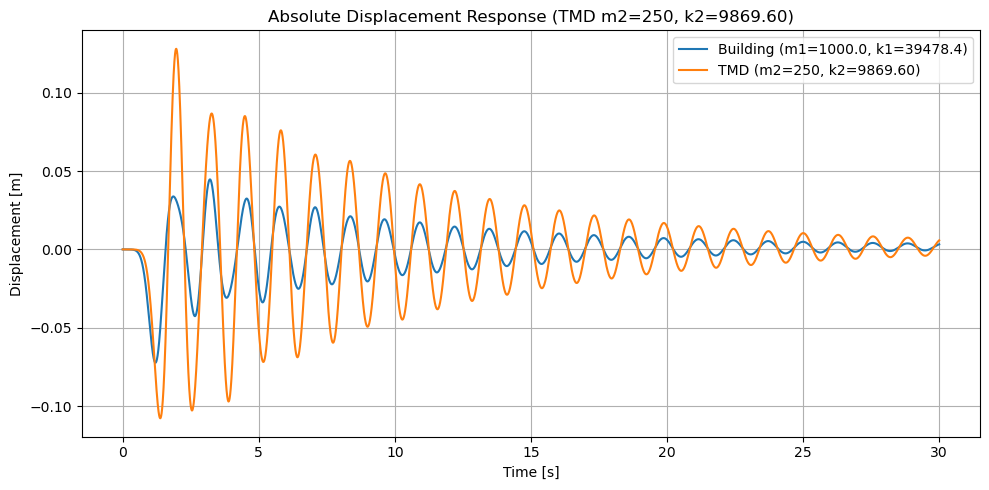

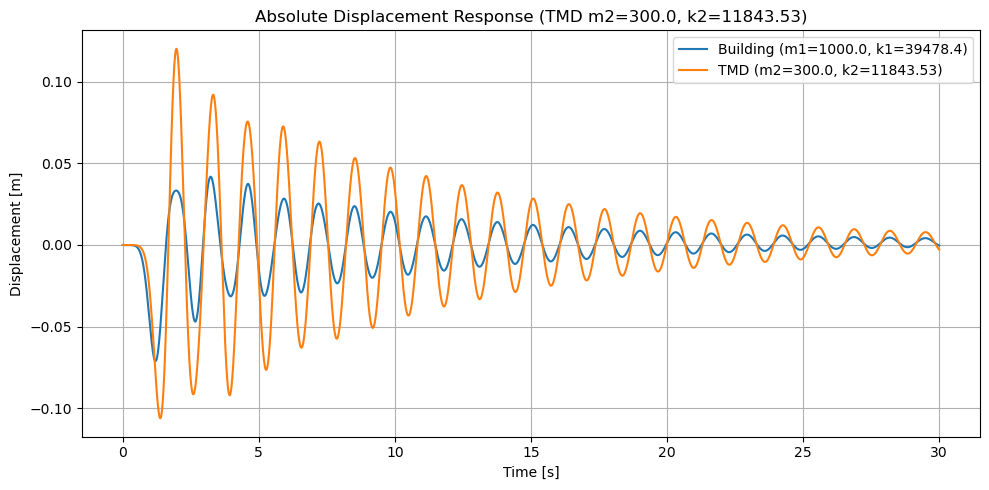

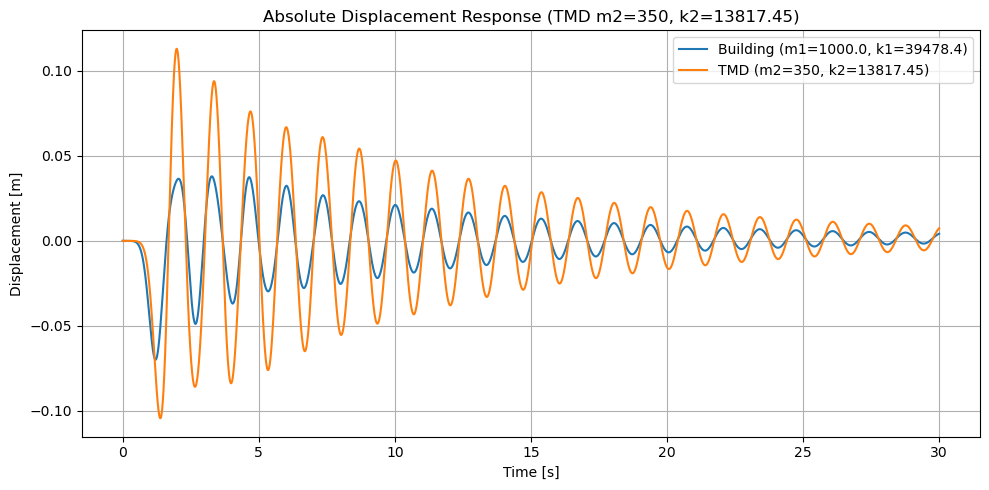

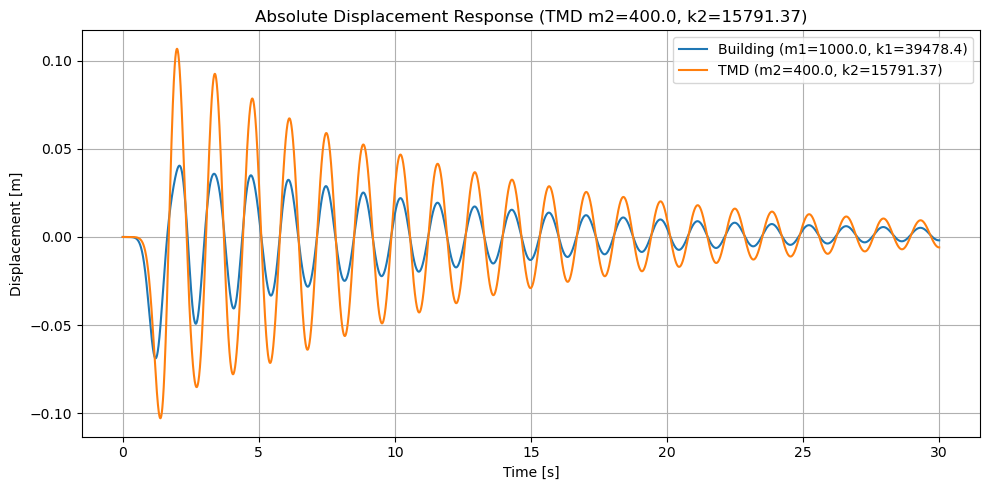

In [24]:
# Sweep example across TMD masses using the numerical solution
m1_fixed = 1000.0
k1_fixed = 39478.41760435743  # ~ (2*pi*1 Hz)^2 * 1000

tmd_masses_to_test = [50, 100.0, 150, 200.0, 250, 300.0, 350, 400.0]
simulation_results = simulate_displacement(
    tmd_masses_to_test, dt, T, zeta1, zeta2,
    m1_fixed=m1_fixed, k1_fixed=k1_fixed, f0=f0, A=A, t_center=t_center
)

for result in simulation_results:
    plt.figure(figsize=(10, 5))
    plt.plot(result['time'], result['displacement'][:, 0],
             label=f"Building (m1={m1_fixed}, k1={k1_fixed:.1f})")
    plt.plot(result['time'], result['displacement'][:, 1],
             label=f"TMD (m2={result['tmd_mass']}, k2={result['tmd_k']:.2f})")
    plt.title(f'Absolute Displacement Response (TMD m2={result["tmd_mass"]}, k2={result["tmd_k"]:.2f})')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

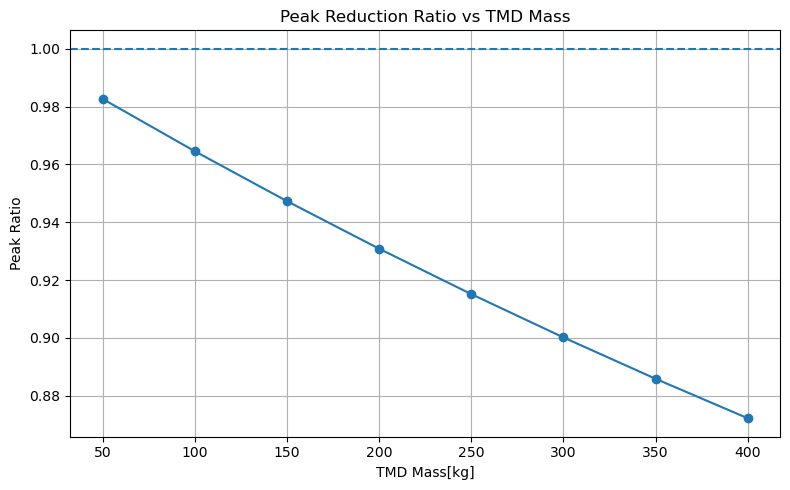

In [25]:
#Baseline (no TMD) using the trapezoidal method
def sdof_trapezoidal(m, k, zeta, ag, dt, T):
    """
    Absolute response u(t) of a single-DOF base-excited oscillator:
        m r¨ + c ṙ + k r = -m ag
    with u = r + xg, where xg is the ground displacement from ag.
    """
    t = np.arange(0, T + dt, dt)
    n = len(t)

    # damping
    omega = np.sqrt(k / m)
    c = 2.0 * zeta * m * omega

    # ground kinematics
    vg = np.cumsum(ag) * dt
    xg = np.cumsum(vg) * dt

    # alloc (relative)
    r      = np.zeros(n)
    r_dot  = np.zeros(n)
    r_ddot = np.zeros(n)

    # effective scalar
    Keff = m + 0.5 * dt * c + 0.25 * dt**2 * k

    # initial accel
    r_ddot[0] = (-c * r_dot[0] - k * r[0] - m * ag[0]) / m

    # step
    for i in range(n - 1):
        F_next = -m * ag[i + 1]
        rhs = (F_next
               - c * (r_dot[i] + 0.5 * dt * r_ddot[i])
               - k * (r[i] + 0.5 * dt * r_dot[i] + 0.25 * dt**2 * r_ddot[i]))
        r_ddot[i + 1] = rhs / Keff
        r_dot[i + 1]  = r_dot[i] + 0.5 * dt * (r_ddot[i] + r_ddot[i + 1])
        r[i + 1]      = r[i]     + dt * r_dot[i] + 0.25 * dt**2 * (r_ddot[i] + r_ddot[i + 1])

    # absolute
    u = r + xg
    u_dot = r_dot + vg
    u_ddot = r_ddot + ag
    return t, u, u_dot, u_ddot

#Compute baseline (no TMD) peak and reduction ratios
t_baseline, u_baseline, _, _ = sdof_trapezoidal(m1_fixed, k1_fixed, zeta1, ag, dt, T)
peak_baseline = np.max(np.abs(u_baseline))

#each case takes the building's absolute displacement (column 0)
mass_list = []
peak_ratio_list = []   # = peak_with_TMD / peak_baseline  (values < 1 mean reduction)

for res in simulation_results:
    u_building = res['displacement'][:, 0]
    peak_with_tmd = np.max(np.abs(u_building))
    ratio = peak_with_tmd / peak_baseline

    mass_list.append(res['tmd_mass'])
    peak_ratio_list.append(ratio)

#Plot: Peak Reduction Ratio vs TMD Mass
plt.figure(figsize=(8, 5))
plt.plot(mass_list, peak_ratio_list, marker='o')
plt.axhline(1.0, linestyle='--')  # baseline reference
plt.title('Peak Reduction Ratio vs TMD Mass')
plt.xlabel('TMD Mass[kg]')
plt.ylabel('Peak Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()



#### Now we will solve for the absolute error between our analytical solution and our numerical solution

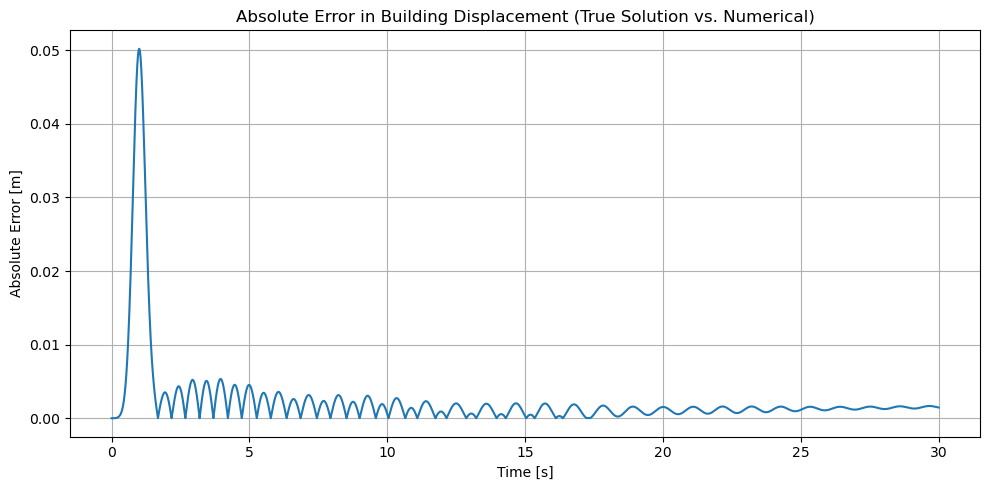

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Re-initalize Variables 
m1 = 1000.0     # Mass Building [kg]
f1 = 1.0        # Natural frequency of building [Hz]
zeta1 = 0.02    # Damping ratio of building
TMD_ratio = .02 # Ratio of TMD mass to building mass

m2 = m1*TMD_ratio # Mass TMD [kg]
f2 = 1.0        # Natural frequency of TMD (tuned to f1)
zeta2 = 0.05    # Damping ratio of TMD

f0 = 1.0        # Frequency of Ricker//Earthquake [Hz]
A = 1.0         # Amplitude [m/s^2]
t_center = 1.0  # Peak Time[s]

dt = 0.002      # Time step [s]
T = 30.0        # Total simulation time [s]

# Define the common time array
common_time = np.arange(0, T + dt, dt)

# EOMS
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

k1 = m1 * omega1**2
k2 = m2 * omega2**2
c1 = 2 * zeta1 * m1 * omega1
c2 = 2 * zeta2 * m2 * omega2

M = np.array([[m1, 0],
              [0,  m2]])
C = np.array([[c1 + c2, -c2],
              [-c2,      c2]])
K = np.array([[k1 + k2, -k2],
              [-k2,      k2]])

#Earthquake
def ricker(t, f0):
    a = np.pi * f0 * t
    return (1 - 2 * a**2) * np.exp(-a**2)

ag = A * ricker(common_time - t_center, f0)  # Ground acceleration [m/s^2]

# 4. INITIAL CONDITIONS for numerical method
r = np.zeros((len(common_time), 2))       # Relative displacements
r_dot = np.zeros((len(common_time), 2))   # Relative velocities
r_ddot = np.zeros((len(common_time), 2))  # Relative accelerations

# Initial acceleration from equilibrium
F0 = -M.dot(np.array([1, 1])) * ag[0]
r_ddot[0] = np.linalg.solve(M, F0 - C @ r_dot[0] - K @ r[0])

# 5. TRAPEZOIDAL RULE FORMULATION
K_eff = M + 0.5 * dt * C + 0.25 * dt**2 * K
K_eff_inv = np.linalg.inv(K_eff)

# Trapezoidal rule implementation
for k in range(len(common_time) - 1):
    F_next = -M.dot(np.array([1, 1])) * ag[k + 1]

    rhs = (F_next
           - C.dot(r_dot[k] + 0.5 * dt * r_ddot[k])
           - K.dot(r[k] + 0.5 * dt * r_dot[k] + 0.25 * dt**2 * r_ddot[k]))

    r_ddot[k + 1] = K_eff_inv.dot(rhs)
    r_dot[k + 1] = r_dot[k] + 0.5 * dt * (r_ddot[k] + r_ddot[k + 1])
    r[k + 1] = r[k] + dt * r_dot[k] + 0.25 * dt**2 * (r_ddot[k] + r_ddot[k + 1])

# 7. ABSOLUTE MOTION (numerical method)
vg = np.cumsum(ag) * dt
xg = np.cumsum(vg) * dt
u_numerical = r + xg.reshape(-1, 1) * np.array([1, 1])


#Code for the true solution using solve_ivp
# State equations
def xdot(t_true, x):
    x1, x2, x3, x4 = x  # [u1, u1dot, u2, u2dot]
    dx1 = x2
    dx2 = (1.0/m1) * ( -m1*ricker(t_true - t_center, f0) - (c1+c2)*x2 + c2*x4 - (k1+k2)*x1 + k2*x3 )
    dx3 = x4
    dx4 = (1.0/m2) * ( c2*(x2 - x4) + k2*(x1 - x3) )
    return [dx1, dx2, dx3, dx4]

# Initial conditions and time span for true solutions
x0 = [0.0, 0.0, 0.0, 0.0]
t_span = (0.0, T)

# Integrate for true solution using the common_time array
sol = solve_ivp(xdot, t_span, x0, t_eval=common_time, rtol=1e-8, atol=1e-10)

u_true = sol.y[0] # Building displacement from the true solution

#Calculate and Plot Absolute Error
# Since we used the common_time array for both, their lengths should match
if len(u_numerical[:, 0]) != len(u_true):
    print(f"Error: The lengths of the displacement arrays do not match.")
    print(f"Numerical length: {len(u_numerical[:, 0])}, True solution length: {len(u_true)}")
else:
    # Calculate the absolute difference in displacement for the building
    displacement_error = np.abs(u_true - u_numerical[:, 0])

    # Plot the absolute error over time
    plt.figure(figsize=(10, 5))
    plt.plot(common_time, displacement_error)
    plt.title('Absolute Error in Building Displacement (True Solution vs. Numerical)')
    plt.xlabel('Time [s]')
    plt.ylabel('Absolute Error [m]')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

